In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")

print(result.content)


Hello. How can I help you today?


In [2]:
# custom tools

def add(a,b):
    """Add two numbers"""
    return a+b

def multiply(a,b):
    """Multiply two numbers"""
    return a*b

def subtract(a,b):
    """Subtract two numbers"""
    return a-b


tools=[add,multiply,subtract]

llm_with_tools=llm.bind_tools(tools)


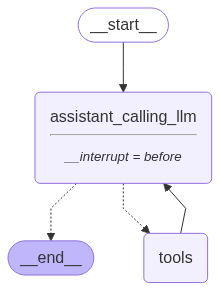

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END ,MessagesState
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image, display


# Nodes

def assistant_calling_llm(state:MessagesState):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


builder=StateGraph(MessagesState)
builder.add_node("assistant_calling_llm", assistant_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant_calling_llm")
builder.add_conditional_edges("assistant_calling_llm", tools_condition)
builder.add_edge("tools", "assistant_calling_llm")


graph=builder.compile(interrupt_before=["assistant_calling_llm"])

display(Image(graph.get_graph().draw_mermaid_png()))



### Human In the Loop
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='\n<think>\nOkay, the user said "Hello". I need to respond politely. Let me think of a friendly greeting. Maybe "Hello! How can I assist you today?" That sounds good. It\'s welcoming and opens the conversation for them to explain what they need. I should make sure there\'s no typos and it\'s concise. Yep, that should work.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 11, 'total_tokens': 95, 'completion_time': 0.203419762, 'prompt_time': 0.002873188, 'queue_time': 0.25746448099999997, 'total_time': 0.20629295}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a56ada6e3f', 'finish_reason': 'stop', 'logprobs': None}, id='run-9dc33991-43e6-4592-8f6c-476da13f5c66-0', usage_metadata={'input_tokens': 11, 'output_tokens': 84, 'total_tokens': 95})

In [ ]:
### Custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]
tools



[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [ ]:
## Integrate tools with llm
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002006E470470>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002006DF999A0>, model_name='qwen-qwq-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b.', 'parameters': {'properties': {'a': {'description': 'first int', '

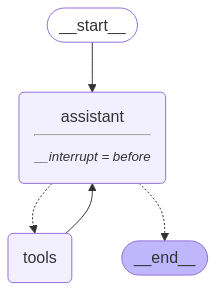

In [ ]:
### WWorkflow with Langgraph
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

## system Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

## node definition
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

#Graph
builder=StateGraph(MessagesState)

## Define nodes: 
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the Edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,

)
builder.add_edge("tools","assistant")

memory=MemorySaver()

### human in the loop
graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))






In [ ]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

In [ ]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
state=graph.get_state(thread)
state.next

('assistant',)

In [ ]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x000002006FED6980>

In [ ]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ae3d97eb-97a2-4fdf-ba9b-3025ade6d8f4')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f01ab4d-82ee-65ff-8002-80411bc8f8fb'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '123', 'step': 2, 'parents': {}}, created_at='2025-04-16T11:20:47.187302+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f01ab4d-82eb-6ef0-8001-b71539d1c5e7'}}, tasks=(PregelTask(id='a72bfa13-c165-c256-296c-a37017bd000c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

![image.png](attachment:image.png)

In [ ]:
## Continue the execution to Assistant
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_z7ed)
 Call ID: call_z7ed
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [ ]:
state=graph.get_state(thread)
state.next

('assistant',)

In [ ]:
## Continue the execution of Assistant and then end
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.

<final_answer>
6
</final_answer>


### Edit Human Feedback

In [ ]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
state=graph.get_state(thread)
state.next

('assistant',)

In [ ]:
graph.update_state(thread,{"messages":[HumanMessage(content="No,please multiply 15 and 6")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01abdb-f66c-6ea0-8001-4e8d367673c7'}}

In [ ]:
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,please multiply 15 and 6


In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No,please multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3qk7)
 Call ID: call_3qk7
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

The result of multiplying 15 and 6 is **90**.


### Workflow will Wait for the User Input

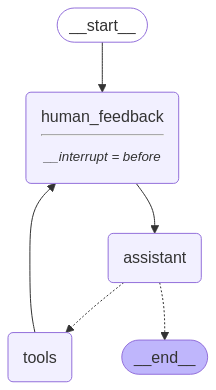

In [ ]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


## Human feedback node

def human_feedback(state:MessagesState):
    pass

### Assistant node
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Graph

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)


## Define the edges
builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","human_feedback")

memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

## get user input

user_input=input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

please multiply 5 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zvhz)
 Call ID: call_zvhz
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30


In [ ]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

30
